In [1]:
## Notebook env: mirtud_env (mirtud_env kernel)
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
%load_ext rpy2.ipython

### get rpy2 autocompletion 
from rpy2.robjects import r
from IPython import get_ipython

def rpy2_completer(ipython, event):
    query = event.line.strip().split()[-1]
    suggestions = []
    all_r_symbols = r('sapply(search(), ls)')
    for environment, symbols in all_r_symbols.items():
        for _, symbol in symbols.items():
            if symbol.startswith(query):
                suggestions.append(symbol)
    return suggestions

get_ipython().set_hook('complete_command', rpy2_completer, re_key='.*')

# Processing data before loading to Seurat (skip after first time)

In [2]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [3]:
scipy.io.mmwrite('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw.mtx', adata.X)

In [4]:
## get meta data
meta_adata = sc.get.obs_df(adata, keys = adata.obs.columns.tolist())
meta_adata.to_csv('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw_meta.csv')

In [5]:
genes = sc.get.var_df(adata)
genes.to_csv('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw_genes.csv', header=False)

# Loading into Seurat

In [2]:
%%R
library(Seurat)
library(Matrix)
library(ggplot2)
library(ggpubr)



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Attaching SeuratObject


In [3]:
%%R
file_path = '/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw.mtx'
raw = readMM(file_path)
raw = t(raw)


In [4]:
%%R
meta = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw_meta.csv', row.names = 1)
head(meta, 5)

                         sample          barcode                  guide
tRF_1:AAACCCAAGGCCTTGC-1  tRF_1 AAACCCAAGGCCTTGC              TuD_NC_01
tRF_1:AAACCCACATATACCG-1  tRF_1 AAACCCACATATACCG tRNA-Arg-ACG-(3)1-1.lh
tRF_1:AAACCCACATGACAGG-1  tRF_1 AAACCCACATGACAGG              TuD_NC_01
tRF_1:AAACCCACATGACGGA-1  tRF_1 AAACCCACATGACGGA tRNA-Arg-ACG-(3)1-1.rh
tRF_1:AAACCCAGTCAACCAT-1  tRF_1 AAACCCAGTCAACCAT              TuD_NC_01
                              lor        pvalue    adj_pvalue max_umi n_umi
tRF_1:AAACCCAAGGCCTTGC-1 2.192020  1.181708e-15  1.316436e-08      23    32
tRF_1:AAACCCACATATACCG-1 6.995509 4.940656e-324 5.503946e-317     178   210
tRF_1:AAACCCACATGACAGG-1 2.438652  1.292626e-21  1.440000e-14      36    53
tRF_1:AAACCCACATGACGGA-1 1.154620 4.940656e-324 5.503946e-317     196   355
tRF_1:AAACCCAGTCAACCAT-1 3.182463  3.777568e-25  4.208253e-18      38    51
                              m_umi      v_umi log_max_umi log_n_umi  log_m_umi
tRF_1:AAACCCAAGGCCTTGC-1 0.07804

In [5]:
%%R
gene_names = read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/tRF_raw_genes.csv', header = FALSE)
gene_names = gene_names$V1

In [6]:
%%R
colnames(raw) <- rownames(meta)
rownames(raw) <- gene_names

In [7]:
%%R
tRF_seurat <- CreateSeuratObject(raw, meta.data = meta)

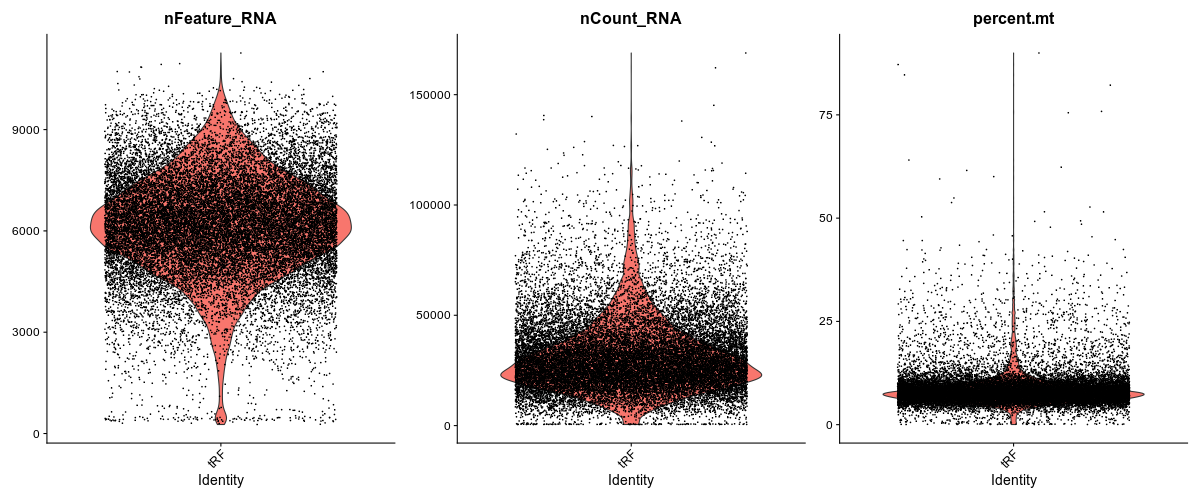

In [8]:
%%R -w 1200 -h 500
tRF_seurat[["percent.mt"]] <- PercentageFeatureSet(tRF_seurat, pattern = "^MT-")
VlnPlot(tRF_seurat, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)


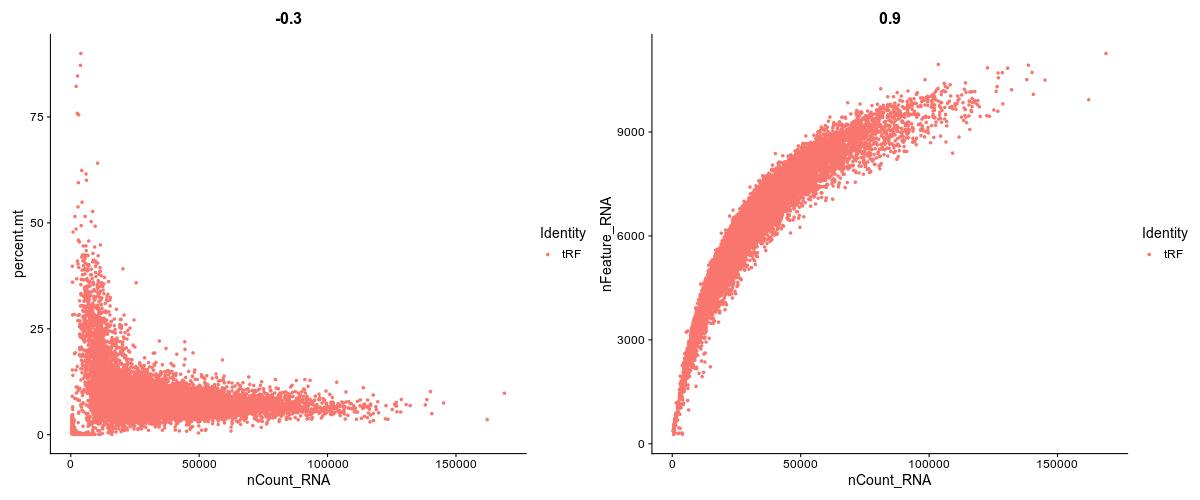

In [9]:
%%R -w 1200 -h 500
plot1 <- FeatureScatter(tRF_seurat, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(tRF_seurat, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
options(repr.plot.width=10, repr.plot.height=10)
plot1 + plot2

In [10]:
%%R
tRF_seurat <- SCTransform(tRF_seurat, vars.to.regress = c("percent.mt", "nCount_RNA"), verbose = TRUE)
tRF_seurat <- RunPCA(object = tRF_seurat)
tRF_seurat <- FindNeighbors(object = tRF_seurat)
tRF_seurat <- FindClusters(object = tRF_seurat)



  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22465
Number of edges: 686542

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8485
Number of communities: 15
Elapsed time: 4 seconds


Calculating cell attributes from input UMI matrix: log_umi
Variance stabilizing transformation of count matrix of size 28083 by 22465
Model formula is y ~ log_umi
Get Negative Binomial regression parameters per gene
Using 2000 genes, 5000 cells
Found 68 outliers - those will be ignored in fitting/regularization step

Second step: Get residuals using fitted parameters for 28083 genes
Computing corrected count matrix for 28083 genes
Calculating gene attributes
Wall clock passed: Time difference of 6.032903 mins
Determine variable features
Place corrected count matrix in counts slot
Regressing out percent.mt, nCount_RNA
  |======================================================================| 100%
Centering data matrix
  |======================================================================| 100%
Set default assay to SCT
PC_ 1 
Positive:  ANKRD1, NEAT1, FAM155A, MAGI1, FHIT, EFNA5, LIMCH1, TIMP3, PDLIM5, RBMS3 
	   IMMP2L, MAML2, GPC6, RASAL2, RAD51B, MIR100HG, FAM111B, TGFB2, SMYD3, MA

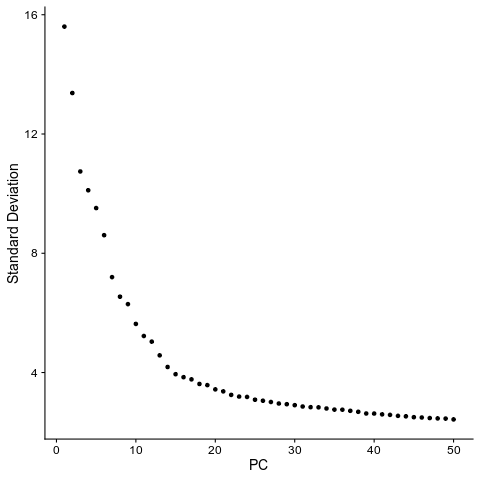

In [11]:
%%R
ElbowPlot(tRF_seurat, ndims = 50, reduction = 'pca')

In [12]:
%%R
tRF_seurat <- RunUMAP(object = tRF_seurat, dims = 1:30)

To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session
14:54:11 UMAP embedding parameters a = 0.9922 b = 1.112
14:54:11 Read 22465 rows and found 30 numeric columns
14:54:11 Using Annoy for neighbor search, n_neighbors = 30
14:54:11 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
14:54:14 Writing NN index file to temp file /tmp/Rtmp8u5kyz/file16a99f1fe354d6
14:54:14 Searching Annoy index using 1 thread, search_k = 3000
14:54:21 Annoy recall = 100%
14:54:22 Commencing smooth kNN distance calibration using 1 thread with target n_neighbors = 30
14:54:24 Initializing from normalized Laplacian + noise (using irlba)
14:54:25 Commencing optimization for 200 epochs, with 964038 positive edges
Using method 'umap'
0%   10   20   30   40   50   60   

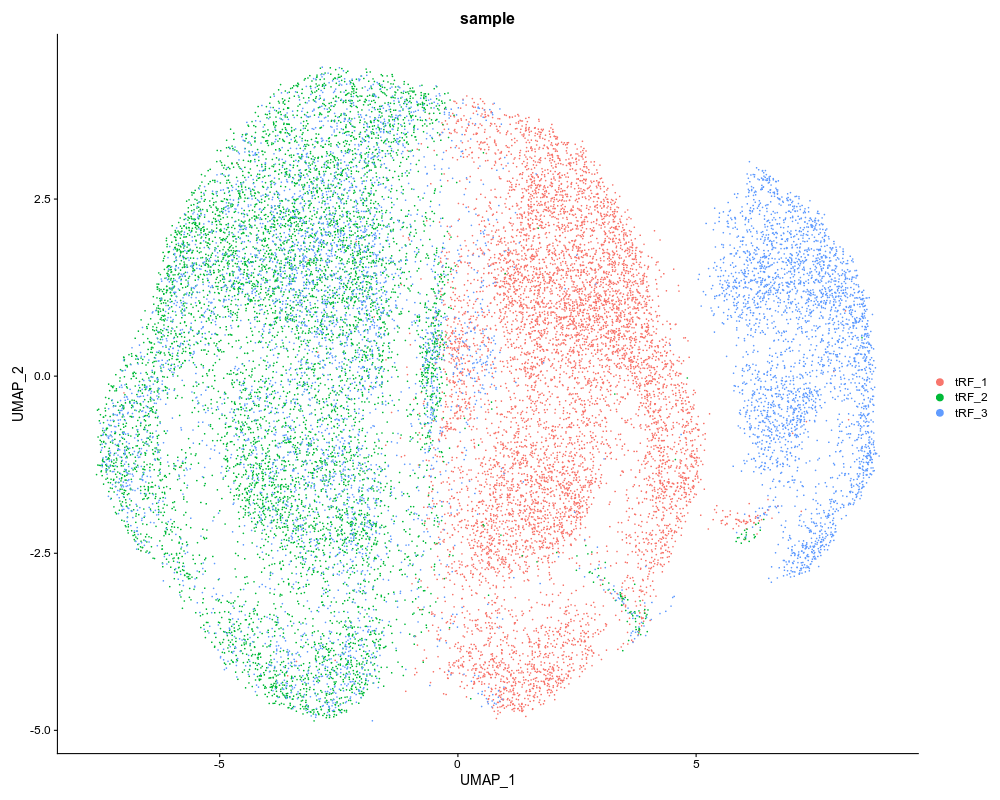

In [13]:
%%R -w 1000 -h 800
DimPlot(object = tRF_seurat, reduction = "umap", group.by = "sample")

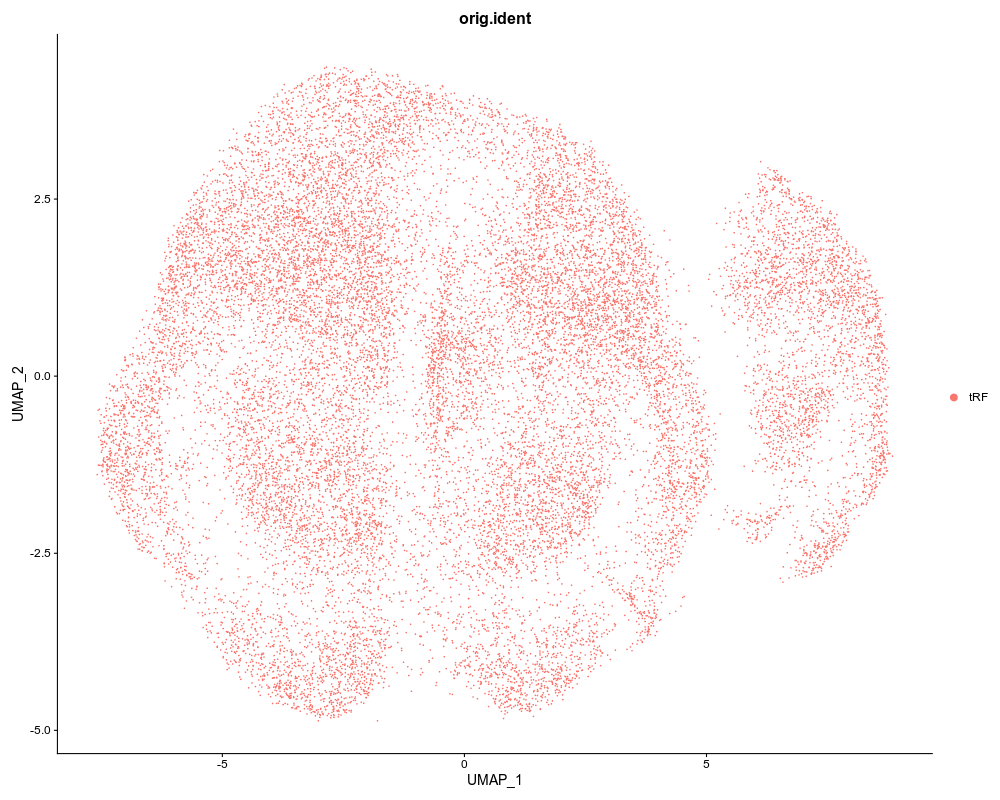

In [16]:
%%R -w 1000 -h 800
DimPlot(object = tRF_seurat, reduction = "umap", group.by = "orig.ident")

In [ ]:
%%R
## save Seurat object
saveRDS(tRF_seurat, '/home/ssobti/projects/mir_tud/output_data/seurat/tRF_seuratobj.RData')

In [18]:
%%R -w 1000 -h 1000
umaps <- rep(list('empty'), length(unique(meta$guide)))
perturbs <- unique(meta$guide)
for (i in 1:length(perturbs)){
    nms <- rownames(meta)[meta$guide == perturbs[i]]
    umaps[[i]] <- DimPlot(object = tRF_seurat, reduction = "umap", group.by = "guide", cells.highlight = nms, cols.highlight = "red", cols = "grey90") + ggtitle(perturbs[i])
}


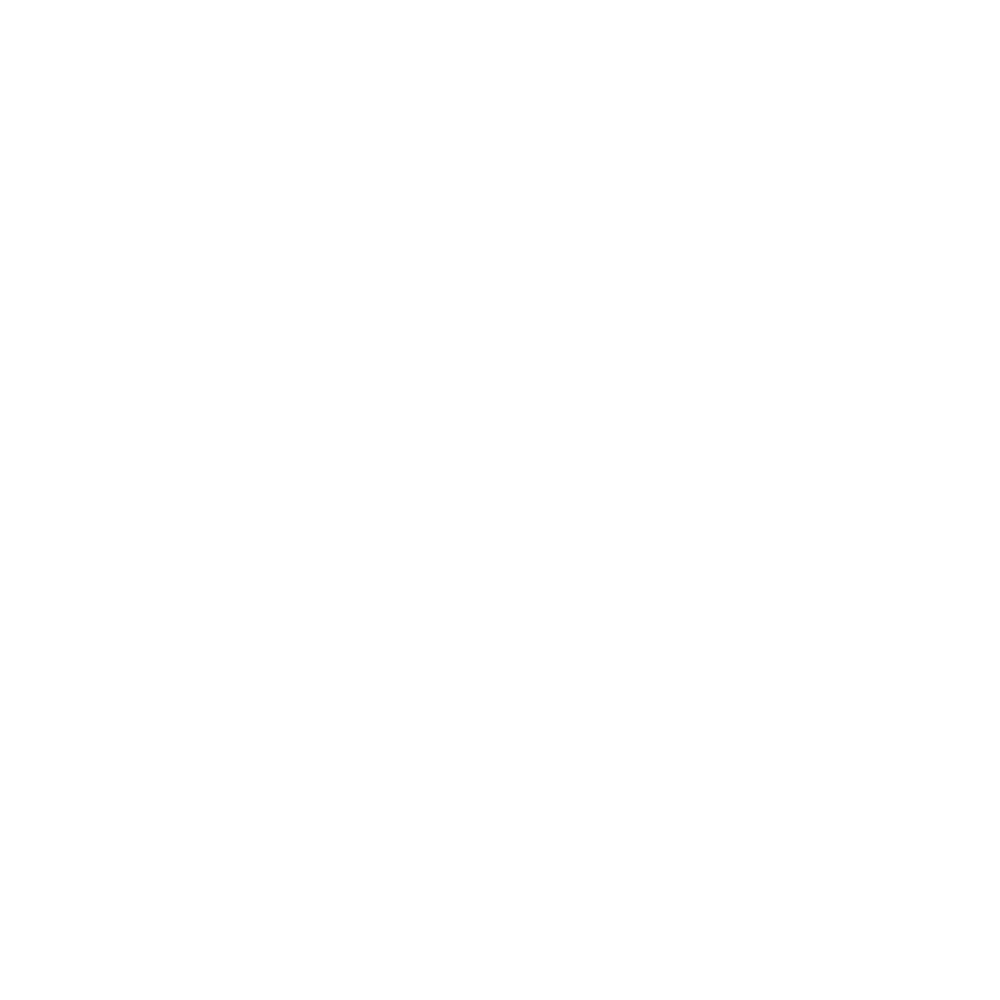

In [19]:
%%R  -w 1000 -h 1000
umap_plts <- rep(list('empty'), ceiling(length(umaps)/25))
for (i in 1:ceiling(length(umaps)/25)){
    umap_plts[[i]] <- ggarrange(plotlist = umaps[(25*(i-1)+1):(25*i)], ncol = 5, nrow = 5, common.legend = TRUE)
}


In [20]:
%%R
pdf('/home/ssobti/projects/mir_tud/output_data/seurat/tRF_perturb_umaps.pdf', height = 12, width = 12)
for (i in 1:length(umap_plts)){
    print(umap_plts[[i]])
}
dev.off()

png 
  2 
